In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
train_csv = 'data/sunspot_train.csv'
test_csv = 'data/sunspot_test.csv'

In [3]:
train_df = pd.read_csv(train_csv, index_col=0)
test_df = pd.read_csv(test_csv, index_col=0)

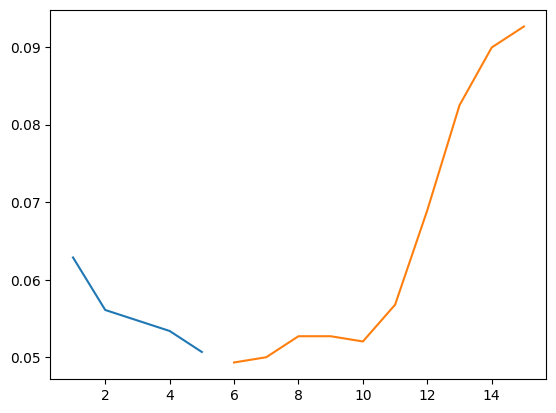

In [4]:
fig, ax = plt.subplots()

ts_input = np.array(range(1, 6))
X_train = train_df.loc[:, [f'Input{i}' for i in ts_input]].values
X_test = test_df.loc[:, [f'Input{i}' for i in ts_input]].values

ts_output = np.array(range(1, 11))
y_train = train_df.loc[:, [f'Output{i}' for i in ts_output]].values
y_test = test_df.loc[:, [f'Output{i}' for i in ts_output]].values

ts_output = ts_output + ts_input[-1]

ax.plot(ts_input, X_train[0])
ax.plot(ts_output, y_train[0])

In [5]:
def tilted_loss(q, y, f):
    e = (y-f)
    return torch.mean(torch.max(q*e, (q-1)*e))

In [6]:
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)

quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
quantile_loss = np.zeros(len(quantiles))

input_size = 5
hidden_size = 256
output_size = 10

lr = 1e-2
num_epochs = 5000

models = [nn.Sequential(
            nn.Linear(input_size, output_size)
        ).double() for q in quantiles]

opts = [torch.optim.Adam(model.parameters(), lr=lr)
       for model in models]

In [7]:
quantile_loss = np.zeros(len(quantiles))

# Training loop
for epoch in range(num_epochs):

    for j, (q, model, opt) in enumerate(zip(quantiles, models, opts)):

        model = model.train()

        # Zero the parameter gradients
        opt.zero_grad()

        # Forward pass
        y_pred = model(X_train_tensor)
    
        # Calculate loss
        loss = tilted_loss(q, y_train_tensor, y_pred)
    
        # Backward pass and optimization
        loss.backward()
        opt.step()
        quantile_loss[j] = loss.item()
    
    # Print statistics
    print(f'[{epoch + 1}] loss: {quantile_loss}')
    # print('[%d] loss: %.3f' %
    #         (epoch + 1, running_loss))

print('Finished Training')

[1] loss: [0.03724036 0.14667548 0.18889363 0.2532862  0.27024741]
[2] loss: [0.03550907 0.1378851  0.17844171 0.23588931 0.25156662]
[3] loss: [0.03383738 0.12924343 0.1689643  0.21890431 0.23375474]
[4] loss: [0.0322184  0.1208404  0.16042053 0.20232926 0.21677142]
[5] loss: [0.0306726  0.11274686 0.15237892 0.18614698 0.20043918]
[6] loss: [0.02924939 0.1053392  0.14469274 0.17045916 0.18483985]
[7] loss: [0.02795186 0.09874478 0.13722136 0.15562026 0.17004504]
[8] loss: [0.0267529  0.09306847 0.12990367 0.14153902 0.15619136]
[9] loss: [0.0255222  0.08778858 0.12290654 0.12865238 0.14324843]
[10] loss: [0.02426518 0.08246274 0.11622424 0.11737929 0.13121755]
[11] loss: [0.02301945 0.07713836 0.1098964  0.10748032 0.11995891]
[12] loss: [0.02184497 0.07187761 0.10396738 0.09890058 0.10951508]
[13] loss: [0.02072663 0.0667812  0.09842135 0.09178534 0.09976679]
[14] loss: [0.01964712 0.06205289 0.09320951 0.08586483 0.09079015]
[15] loss: [0.01860084 0.05773886 0.08833579 0.08093216 0

In [10]:
y_pred_list = []
test_quantile_loss = np.zeros(len(quantiles))

X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

for j, (q, model) in enumerate(zip(quantiles, models)):
    model = model.eval()
    y_pred = model(X_test_tensor)
    test_quantile_loss[j] = tilted_loss(q, y_test_tensor, y_pred).item()
    y_pred_list.append(y_pred.detach().numpy())

y_pred = np.stack(y_pred_list, axis=1)
y_pred.shape

(385, 5, 10)

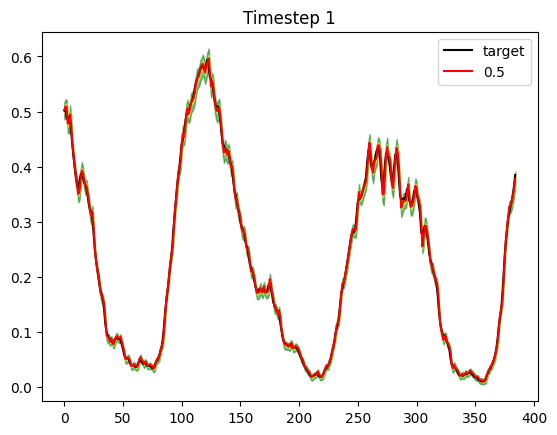

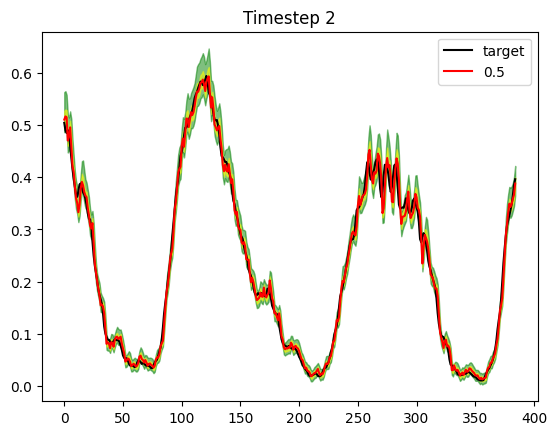

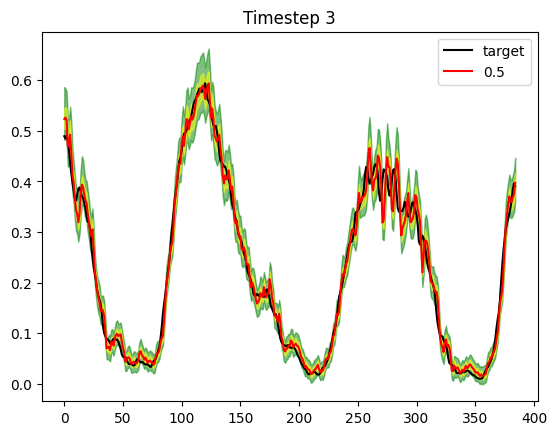

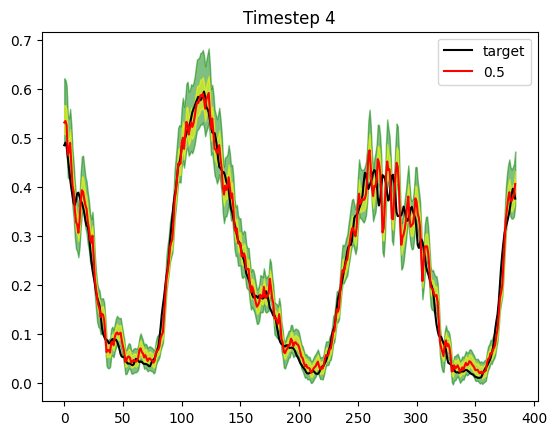

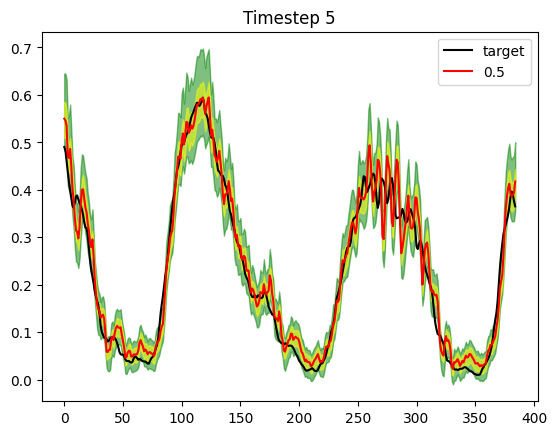

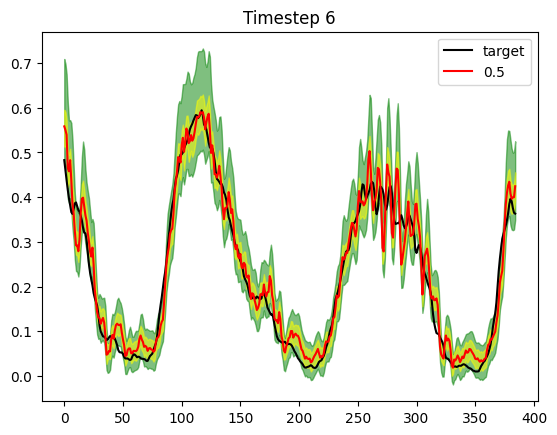

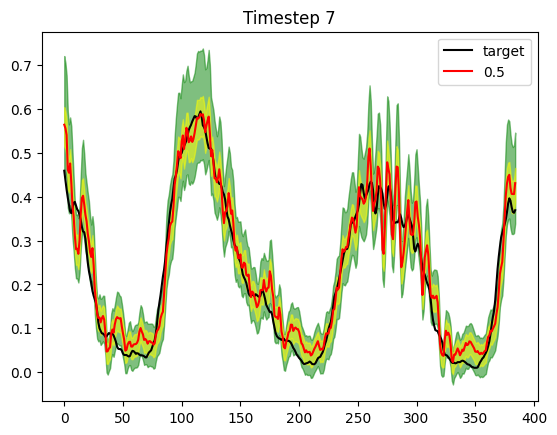

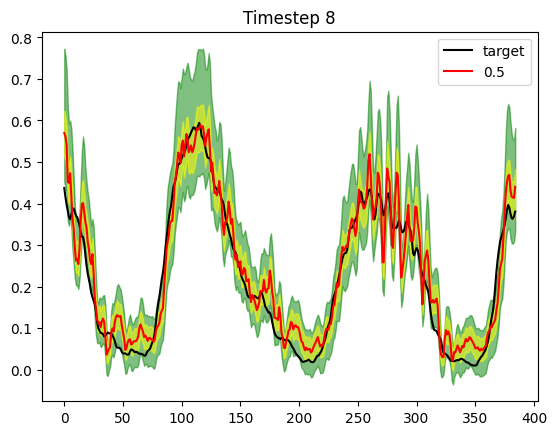

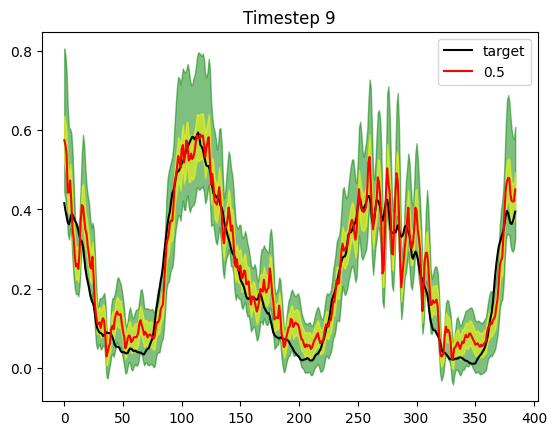

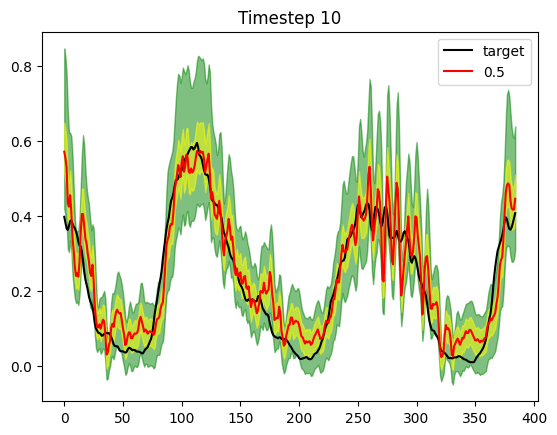

In [9]:
colors = ['green', 'orange', 'red', 'orange', 'green']

for ts in range(10):
    
    fig, ax = plt.subplots()
    ax.plot(y_test[:, ts], color='black', label='target')
    
    # for i, q in enumerate(quantiles):
    ax.plot(y_pred[:, 2, ts], color=colors[2], label=0.5)
    ax.fill_between(range(len(y_pred)),  y_pred[:, 0, ts], y_pred[:, -1, ts], alpha=0.5, color='green')
    ax.fill_between(range(len(y_pred)),  y_pred[:, 1, ts], y_pred[:, -2, ts], alpha=0.5, color='yellow')

    ax.set_title(f'Timestep {ts+1}')
    plt.legend()

In [11]:
test_quantile_loss

array([0.00320649, 0.01050377, 0.01395789, 0.01205173, 0.00455394])